In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda
import matplotlib.pyplot as plt

import configs
from configs import device


In [2]:
training_data = datasets.MNIST(
    root=configs.dataset_path,
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=Lambda(lambda y: torch.zeros(10).scatter_(0, torch.tensor(y), 1))
)

test_data = datasets.MNIST(
    root=configs.dataset_path,
    train=False,
    download=True,
    transform=ToTensor()
)

In [3]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True, pin_memory_device='cuda')
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True, num_workers=8, pin_memory=True, pin_memory_device='cuda')

In [4]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    batch_size = dataloader.batch_size
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader , model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred: torch.Tensor = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item()
            correct += (y_pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return (100*correct, test_loss)




In [5]:
# from shallowNeuralNetwork import NeuralNetwork 
# model = NeuralNetwork().to(device)
from deepNeuralNetwork import NeuralNetwork 
model = NeuralNetwork(
        input_size=28*28, 
        hidden_sizes= [512, 512, 512, 512], 
        output_size=10
    ).to(device)


In [6]:

epochs = 100
lr = 0.005
# epochs = 20
# lr = 0.01

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
accuracies = []
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer)
    accuracy, currloss =test_loop(test_dataloader, model, loss_fn)
    accuracies.append(accuracy)
print("Done!")

Epoch 1
-------------------------------
loss: 2.303065  [   64/60000]
loss: 2.302651  [ 6464/60000]
loss: 2.302549  [12864/60000]
loss: 2.303094  [19264/60000]
loss: 2.302850  [25664/60000]
loss: 2.302724  [32064/60000]
loss: 2.302353  [38464/60000]
loss: 2.302361  [44864/60000]
loss: 2.302592  [51264/60000]
loss: 2.302589  [57664/60000]
Test Error: 
 Accuracy: 10.3%, Avg loss: 2.302449 

Epoch 2
-------------------------------
loss: 2.302651  [   64/60000]
loss: 2.302466  [ 6464/60000]
loss: 2.302584  [12864/60000]
loss: 2.302691  [19264/60000]
loss: 2.302638  [25664/60000]
loss: 2.302510  [32064/60000]
loss: 2.301685  [38464/60000]
loss: 2.302346  [44864/60000]
loss: 2.302381  [51264/60000]
loss: 2.301585  [57664/60000]
Test Error: 
 Accuracy: 10.5%, Avg loss: 2.302316 

Epoch 3
-------------------------------
loss: 2.302214  [   64/60000]
loss: 2.302198  [ 6464/60000]
loss: 2.301441  [12864/60000]
loss: 2.302832  [19264/60000]
loss: 2.301782  [25664/60000]
loss: 2.302077  [32064/600

most accuracy: 97.18


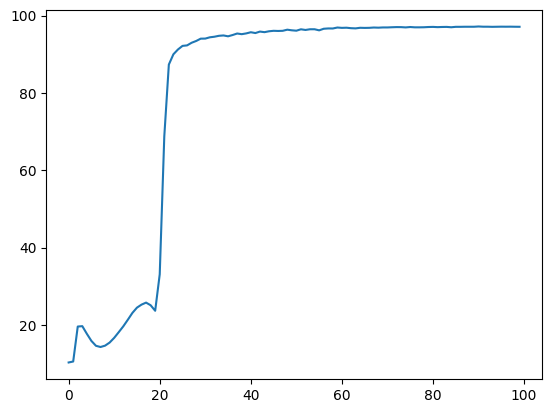

In [7]:
maxpos = torch.tensor(accuracies).argmax()
print(f"most accuracy: {accuracies[maxpos.item()]}")
plt.plot(accuracies)

/tmp/ipykernel_192862/2231731645.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  cuimg = torch.tensor(img).to(device)


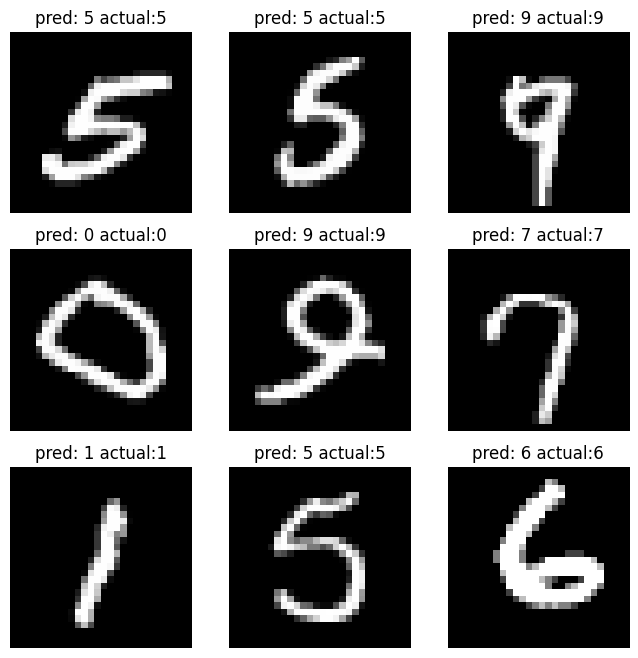

In [13]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3,3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(test_data), size=(1,)).item()
    img, label = test_data[sample_idx]
    cuimg = torch.tensor(img).to(device)
    pred = model(cuimg)
    pred_label = pred.argmax(1).item()
    figure.add_subplot(rows, cols, i)
    plt.title(f"pred: {pred_label} actual:{label}")
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

saving the shallow nn models:

In [14]:
torch.save(model.state_dict(), f'./trained_models/{model.nntype}NNweights.pth')
torch.save(model, f'./trained_models/{model.nntype}NN.pth')